In [1]:
import itertools
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering

In [2]:
data = pd.read_csv('../data/processed/processed.csv')

In [3]:
affinities = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
linkages = ['complete', 'average', 'single']
combinations = list(itertools.product(affinities, linkages))

# Ward can only be combined with euclidean distance
combinations.append(('euclidean','ward'))

In [4]:
data_rows = len(data)
scores = []
thresholds = np.arange(0.1, 10, 0.1)

for affinity, linkage in combinations: 
    for threshold in thresholds: 
        ac = AgglomerativeClustering(n_clusters=None, affinity=affinity, linkage=linkage, distance_threshold=threshold)
        prediction = ac.fit_predict(X=data)
        
        if ac.n_clusters_ == 1 or ac.n_clusters_ == data_rows:
            sc, db, ch = -math.inf, math.inf, -math.inf
        else:
            sc = silhouette_score(data, prediction)
            db = davies_bouldin_score(data, prediction)
            ch = calinski_harabasz_score(data, prediction)
        
        scores.append((affinity, linkage, threshold, sc, db, ch, prediction, ac.n_clusters_))

In [5]:
tested_affinities, tested_linkages, thresholds, scs, dbs, chs, predictions, n_clusters = zip(*scores)
placings_per_alt = {}

for i in range(len(scores)):
    placings_per_alt[(tested_affinities[i], tested_linkages[i], thresholds[i])] = {
        'affinity': tested_affinities[i],
        'linkage': tested_linkages[i],
        'threshold': thresholds[i],
        'silhouette coefficient': scs[i],
        'davies-bouldin index': dbs[i],
        'calinski-harabasz index': chs[i],
        'prediction': predictions[i],
        'clusters': n_clusters[i]
    }

sorted_by_max_sc = sorted(scores, key=lambda score: score[3], reverse=True)
sorted_by_min_db = sorted(scores, key=lambda score: score[4], reverse=False)
sorted_by_max_ch = sorted(scores, key=lambda score: score[5], reverse=True)

for index, score in enumerate(sorted_by_max_sc):
    placings_per_alt[(score[0], score[1], score[2])]['max_sc'] = index

for index, score in enumerate(sorted_by_min_db):
    placings_per_alt[(score[0], score[1], score[2])]['min_db'] = index

for index, score in enumerate(sorted_by_max_ch):
    placings_per_alt[(score[0], score[1], score[2])]['max_ch'] = index

In [6]:
def overall_placing(score):
    alt = placings_per_alt[(score[0], score[1], score[2])]
    return (alt['max_sc'] + alt['min_db'] + alt['max_ch']) / 3

sorted_scores_on_overall = sorted(scores, key=overall_placing, reverse=False)

for index, score in enumerate(sorted_scores_on_overall):
    placings_per_alt[(score[0], score[1], score[2])]['overall'] = index

alternatives = sorted(placings_per_alt.values(), key=lambda alt: alt['overall'])
alternatives = [alternative.values() for alternative in alternatives]

In [15]:
sorted_test_affinities, sorted_test_linkages, sorted_thresholds, sorted_scs, sorted_dbs, sorted_chs, sorted_predictions, sorted_clusters, sorted_placing_sc, sorted_placing_db, sorted_placing_ch, sorted_overall = zip(*alternatives)

In [16]:
def points_in_clusters(distribution):
    amount_of_points_in_cluster = {}
    for cluster_id in distribution:
        if cluster_id in amount_of_points_in_cluster:
            amount_of_points_in_cluster[cluster_id] += 1
        else:
            amount_of_points_in_cluster[cluster_id] = 1
    points_in_cluster_descending = sorted(list(amount_of_points_in_cluster.values()), reverse=True)
    return tuple(points_in_cluster_descending)

In [20]:
def print_info(i):
    print(
        f'{sorted_overall[i]:>2}. '
        f'affinity={sorted_test_affinities[i]:>9}, linkage={sorted_test_linkages[i]:>8}, d_threshold={sorted_thresholds[i]:.1f}.'
        f' Scores: SC={sorted_scs[i]:.2f}, DB={sorted_dbs[i]:.2f}, CH={sorted_chs[i]:>6.2f}. '
        f'Clusters: {str(points_in_clusters(sorted_predictions[i]))[:20]:<20}')

In [21]:
top_amount = 30

for i in range(top_amount):
    print_info(i)

 0. affinity=euclidean, linkage= average, d_threshold=1.6. Scores: SC=0.54, DB=0.33, CH=  8.04. Clusters: (209, 1)            
 1. affinity=euclidean, linkage= average, d_threshold=1.7. Scores: SC=0.54, DB=0.33, CH=  8.04. Clusters: (209, 1)            
 2. affinity=euclidean, linkage= average, d_threshold=1.8. Scores: SC=0.54, DB=0.33, CH=  8.04. Clusters: (209, 1)            
 3. affinity=euclidean, linkage= average, d_threshold=1.9. Scores: SC=0.54, DB=0.33, CH=  8.04. Clusters: (209, 1)            
 4. affinity=euclidean, linkage= average, d_threshold=2.0. Scores: SC=0.54, DB=0.33, CH=  8.04. Clusters: (209, 1)            
 5. affinity=euclidean, linkage=  single, d_threshold=0.7. Scores: SC=0.54, DB=0.33, CH=  8.04. Clusters: (209, 1)            
 6. affinity=euclidean, linkage=  single, d_threshold=0.8. Scores: SC=0.54, DB=0.33, CH=  8.04. Clusters: (209, 1)            
 7. affinity=euclidean, linkage=  single, d_threshold=0.9. Scores: SC=0.54, DB=0.33, CH=  8.04. Clusters: (209,

In [22]:
def is_trivial(i):
    return (
        sorted_clusters[i] >= 208
        or points_in_clusters(sorted_predictions[i])[0] >= 208
        or len(points_in_clusters(sorted_predictions[i])) >= 100
    )

top_no_trivial = [i for i in range(len(sorted_overall)) if not is_trivial(i)][:top_amount]

for i in top_no_trivial:
    print_info(i)


23. affinity=euclidean, linkage=    ward, d_threshold=5.2. Scores: SC=0.27, DB=1.23, CH= 97.37. Clusters: (137, 73)           
25. affinity=euclidean, linkage=    ward, d_threshold=5.3. Scores: SC=0.27, DB=1.23, CH= 97.37. Clusters: (137, 73)           
28. affinity=euclidean, linkage=    ward, d_threshold=5.4. Scores: SC=0.27, DB=1.23, CH= 97.37. Clusters: (137, 73)           
31. affinity=euclidean, linkage=    ward, d_threshold=5.5. Scores: SC=0.27, DB=1.23, CH= 97.37. Clusters: (137, 73)           
33. affinity=euclidean, linkage=    ward, d_threshold=5.6. Scores: SC=0.27, DB=1.23, CH= 97.37. Clusters: (137, 73)           
36. affinity=euclidean, linkage=    ward, d_threshold=5.7. Scores: SC=0.27, DB=1.23, CH= 97.37. Clusters: (137, 73)           
39. affinity=euclidean, linkage=    ward, d_threshold=5.8. Scores: SC=0.27, DB=1.23, CH= 97.37. Clusters: (137, 73)           
43. affinity=euclidean, linkage=    ward, d_threshold=5.9. Scores: SC=0.27, DB=1.23, CH= 97.37. Clusters: (137,

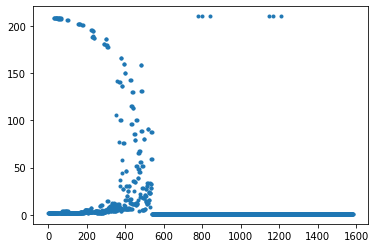

In [10]:
plt.plot(sorted_overall, sorted_clusters,'.')
plt.show()


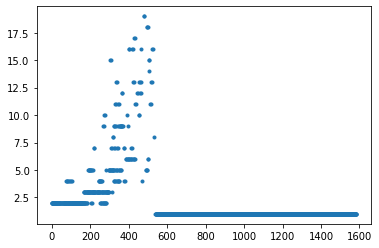

In [11]:
clusterings_under_20 = [(index, cluster_amount) for index, cluster_amount in enumerate(sorted_clusters) if cluster_amount < 20 ]
indexes_u20, cluster_amount_u20 = zip(*clusterings_under_20)

plt.plot(indexes_u20, cluster_amount_u20,'.')
plt.show()
